In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Step 1: Data Preprocessing  

### Overview  
Preprocess the dataset to prepare it for intracranial hemorrhage detection. The main tasks include:  
- Loading and filtering the dataset to include only hemorrhage cases.  
- Splitting and reorganizing the data for clarity and usability.  
- Defining subcategories for hemorrhage types and creating binary labels.  
- Balancing the dataset to ensure equal representation of each subcategory.   

### Output  
- A balanced dataset containing 3000 images (500 from each subcategory).  
- The processed dataset is saved as `balanced_out.csv`.  


In [4]:
#Step1- Data preproccesing
import pandas as pd
import os
import pydicom
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
from PIL import Image
import numpy as np

# Load the dataset
df = pd.read_csv('/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')

# Define the train directory path
train_path = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/'

# List all DICOM file names from the directory
CT_image_file_names = os.listdir(train_path)

# Filter the dataset for hemorrhage cases (Label == 1)
df = df[df['Label'] == 1]

# Function to split the ID column manually
def split_id(id_value):
    parts = id_value.split('_', 2)
    return parts[1], parts[2] if len(parts) > 2 else 'N/A'

# Apply the function to split the ID and create new columns
df[['File', 'Subcategory']] = df['ID'].apply(split_id).apply(pd.Series)

# Drop the 'ID' column
df = df.drop(columns=['ID'])

# Rearrange the columns and rename them for clarity
df = df[['File', 'Subcategory', 'Label']]
df.columns = ['File Name', 'Subcategory', 'Label']

# Add 'ID_' prefix to the 'File Name' column
df['File Name'] = 'ID_' + df['File Name']

# Define subcategories
subcategories = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']

# Create binary columns for each subcategory
for subcategory in subcategories:
    df[subcategory] = df.apply(lambda row: 1 if row['Subcategory'] == subcategory and row['Label'] == 1 else 0, axis=1)

# Drop 'Subcategory' and 'Label' columns
df = df.drop(columns=['Subcategory', 'Label'])

# Aggregate by 'File Name', taking the maximum value for each subcategory column
df_aggregated = df.groupby('File Name').max().reset_index()

# Save the 'File Name' values into a list
file_names_list = df_aggregated['File Name'].tolist()

# Create a DataFrame for DICOM image paths
ICH_dicom_image_paths = pd.DataFrame({
    'File Name': [n for n in file_names_list],
    'image_path': [train_path + n + '.dcm' for n in file_names_list]
})

# Merge the image paths with the aggregated data
merged_df = pd.merge(left=ICH_dicom_image_paths, right=df_aggregated, on='File Name', how='inner')

# --- Equal Sampling from Each Subcategory ---

# Ensure there are 500 images from each subcategory
balanced_df = pd.DataFrame()

for subcategory in subcategories:
    # Filter the dataset by subcategory
    subcategory_df = merged_df[merged_df[subcategory] == 1]
    
    # Sample 500 images for this subcategory
    sampled_df = subcategory_df.sample(n=500, random_state=42)  # Adjust random_state for reproducibility
    
    # Append to the balanced dataframe
    balanced_df = pd.concat([balanced_df, sampled_df])

# Shuffle the final balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the shape of the balanced dataset (should be 600 images)
print(f"Balanced dataset shape: {balanced_df.shape}")

# Save the balanced DataFrame
balanced_df.to_csv('/kaggle/working/balanced_out.csv', index=False)

Balanced dataset shape: (3000, 8)


In [35]:
# This is just to know hom many images were there
# Count occurrences of each subcategory

subcategory_counts = {}

for subcategory in subcategories:
    # Count the number of rows where the subcategory column is 1
    count = df_aggregated[subcategory].sum()
    subcategory_counts[subcategory] = count

# Print the counts in the desired format
for subcategory, count in subcategory_counts.items():
    print(f"Number of images of {subcategory.capitalize()} is: {count}")

Number of images of Epidural is: 3145
Number of images of Intraparenchymal is: 36118
Number of images of Intraventricular is: 26205
Number of images of Subarachnoid is: 35675
Number of images of Subdural is: 47166
Number of images of Any is: 107933


# Step 2: Image Visualization for Detection

### Overview  
In this step, I'm to will visualize five sample images for each subcategory of intracranial hemorrhage. The process involves:
- Loading DICOM images from the preprocessed dataset.
- Sampling five images per subcategory.
- Plotting the images in a grid format without displaying the image paths.
  
### Output
- A grid of images, with five images displayed for each of the six subcategories. The subcategories include:
    - Epidural  
    - Intraparenchymal  
    - Intraventricular  
    - Subarachnoid  
    - Subdural  
    - Any  


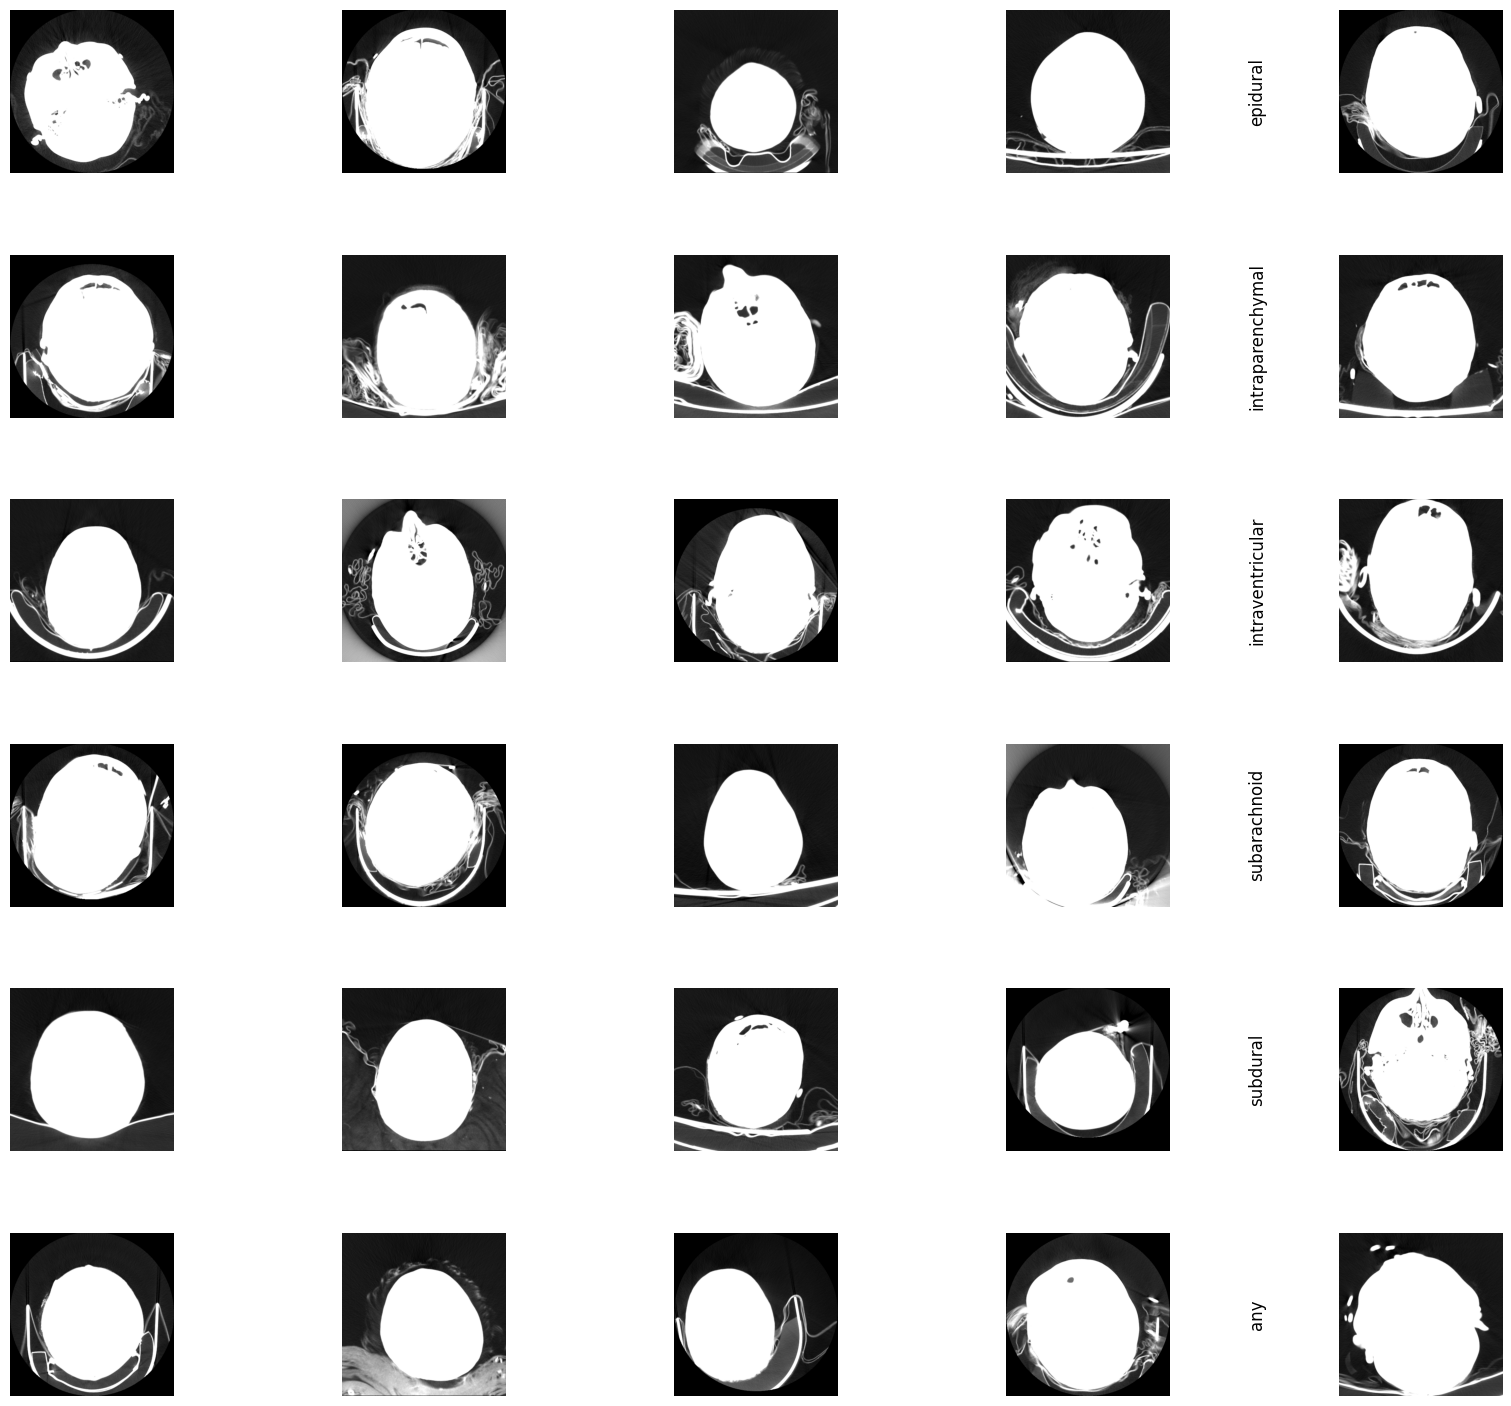

In [5]:
import matplotlib.pyplot as plt
import pydicom
from PIL import Image

# Function to load and preprocess DICOM images
def load_dicom_image(image_path):
    dicom_data = pydicom.dcmread(image_path)
    img_array = dicom_data.pixel_array
    img = Image.fromarray(img_array).convert("RGB")
    return img

# Load the balanced dataset
balanced_df = pd.read_csv('/kaggle/working/balanced_out.csv')

# Create a dictionary to store images and their paths for each subcategory
subcategory_images = {subcategory: [] for subcategory in subcategories}

# Collect five images per subcategory
for subcategory in subcategories:
    subcategory_df = balanced_df[balanced_df[subcategory] == 1]
    sampled_df = subcategory_df.sample(n=5, random_state=42)  # Adjust n as needed
    subcategory_images[subcategory] = [
        (load_dicom_image(row['image_path']), row['image_path']) for _, row in sampled_df.iterrows()
    ]

# Plot the images without paths as titles
fig, axes = plt.subplots(len(subcategories), 5, figsize=(20, 18))  # Increased figure size

for i, subcategory in enumerate(subcategories):
    for j, (img, _) in enumerate(subcategory_images[subcategory]):  # Exclude paths for plot
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis('off')  # Turn off axes
    # Add the subcategory name as a row label
    axes[i, 0].text(-0.5, 0.5, subcategory, fontsize=12, rotation=90, va='center', ha='center', transform=ax.transAxes)

# Manually adjust layout for better spacing
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

# Step 3: DICOM Image Classification using CNN

### Overview
In this step, I'm to train a Convolutional Neural Network (CNN) to classify DICOM images from a dataset of medical images. The process involves:

- Loading the dataset, which includes images in DICOM format and their associated labels.
- Preprocessing the images by applying resizing, normalization, and transformation.
- Defining a CNN model for multi-label classification, and training it using the dataset.
  
### Key Steps

#### 1. **Dataset Class Definition**
A custom dataset class (`RSNADataset`) is defined to handle DICOM images and their corresponding labels. The steps for this include:

- **Loading the DICOM Image**: DICOM images are read using the `pydicom` library.
- **Converting to RGB Format**: If the image is not already in RGB, it is converted.
- **Applying Transformations**: The image is resized, converted to a tensor, and normalized using predefined mean and standard deviation values.

#### 2. **Creating the DataLoader**
Load the dataset using `DataLoader`, which prepares the data for training in batches. The data is shuffled for randomness during training.

#### 3. **Model Definition**
define a simple CNN architecture (`SimpleCNN`) for image classification. The architecture includes:

- **Convolutional Layers**: Two convolutional layers that extract features from images.
- **Pooling Layers**: Max-pooling layers that downsample the feature maps.
- **Fully Connected Layers**: These layers are responsible for outputting the classification results for each subcategory.

#### 4. **Training the Model**
The model is trained for a predefined number of epochs (5 in this case) using the Adam optimizer and binary cross-entropy loss (`BCEWithLogitsLoss`) for multi-label classification. The training process involves:

- Performing forward propagation on input images.
- Calculating the loss using the outputs and true labels.
- Backpropagating the loss to update the weights.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pydicom
from PIL import Image
import numpy as np
from torchvision import transforms

# --- Custom Dataset Class ---
class RSNADataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 1]
        labels = self.dataframe.iloc[idx, 2:].values  # Get binary labels for all subcategories
        
        # Convert labels to float32
        labels = labels.astype(np.float32)

        # Load the DICOM image using pydicom
        dicom_data = pydicom.dcmread(img_path)
        img = dicom_data.pixel_array
        
        # Convert image to PIL Image
        img = Image.fromarray(img)
        
        # Convert single-channel image to 3-channel image (if needed)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Apply transformations if any
        if self.transform:
            img = self.transform(img)
        
        # Return image and labels
        return img, torch.tensor(labels, dtype=torch.float32)

# --- Define Transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# --- Create Dataset and DataLoader ---
dataset = RSNADataset(balanced_df, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# --- Define the CNN Model ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Define the convolutional layers and fully connected layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Input: 3 channels, Output: 16 channels
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # Input: 16 channels, Output: 32 channels
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 kernel
        
        # Calculate the output size after convolutions and pooling
        # 224x224 -> 112x112 -> 56x56 after pooling
        self.fc1 = nn.Linear(32 * 56 * 56, 500)  # Flattened image to 500 nodes
        self.fc2 = nn.Linear(500, 6)  # Output layer for 6 subcategories (multi-label classification)

    def forward(self, x):
        # Convolutional and pooling layers with ReLU activation
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 32 * 56 * 56)  # Adjust this if the input image size changes
        
        # Fully connected layers with ReLU activation
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)  # Output layer (raw logits)
        
        return x

# --- Initialize Model, Optimizer, and Loss Function ---
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use BCEWithLogitsLoss for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# --- Training Loop ---
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        # Calculate loss for multi-label classification
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

print("Training complete!")

Epoch 1/5, Loss: 0.5788
Epoch 2/5, Loss: 0.4783
Epoch 3/5, Loss: 0.4088
Epoch 4/5, Loss: 0.2890
Epoch 5/5, Loss: 0.1410
Training complete!


# Step 4: Data Splitting and DataLoader Creation

### Overview
Split the balanced dataset into training, validation, and test sets, and then create DataLoader objects for each of these subsets. The process involves:

- Splitting the dataset into three parts: 80% for training, 10% for validation, and 10% for testing.
- Creating DataLoaders to load data in batches during model training and evaluation.
  
### Key Steps

#### 1. **Splitting the Dataset**
Begin by splitting the balanced dataset into training, validation, and test sets:

- **Training Set (80%)**: The largest portion is used for model training.
- **Remaining Set (20%)**: The remaining 20% is further split into validation and test sets (each receiving 10% of the total data).

This is achieved using the `train_test_split` function from scikit-learn, ensuring that the splitting is reproducible by setting a random seed.

#### 2. **Creating DataLoaders**
For each of the three sets (training, validation, and test), create a DataLoader:

- **Training DataLoader**: Shuffled to ensure random data distribution during training.
- **Validation and Test DataLoaders**: Do not shuffle, as we use them for evaluation purposes.

Each DataLoader processes the data in batches of 16.

#### 3. **Checking Dataset Sizes**
After splitting the data, print the size of each subset (training, validation, and test sets) to confirm the correct distribution.


In [7]:
from sklearn.model_selection import train_test_split

# Split the balanced dataframe into training (80%) and remaining (20%)
train_df, remaining_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# Split the remaining 20% into validation and test sets (50% of 20% = 10% for each)
val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42)

# Create separate DataLoaders for training, validation, and test sets
train_dataset = RSNADataset(train_df, transform=transform)
val_dataset = RSNADataset(val_df, transform=transform)
test_dataset = RSNADataset(test_df, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print the sizes of each set
print(f"Training set size: {len(train_dataloader.dataset)}")
print(f"Validation set size: {len(val_dataloader.dataset)}")
print(f"Test set size: {len(test_dataloader.dataset)}")

Training set size: 2400
Validation set size: 300
Test set size: 300


# Step 5: Training Loop with Validation

### Overview
In this step, I'm training the model while also evaluating its performance on a validation set at each epoch. The process involves:

- Training the model on the training set and calculating the training loss.
- Validating the model on the validation set and calculating the validation loss.
- Saving the model checkpoint when the validation loss improves.

### Key Steps

#### 1. **Training Phase**
- **Model Training**: The model is set to training mode using `model.train()`. During each iteration, the model processes a batch of images and labels, performs forward propagation, calculates the loss, and updates the model weights using backpropagation.
- **Loss Calculation**: The loss is calculated using `BCEWithLogitsLoss` and accumulated over the batches in the training set.

#### 2. **Validation Phase**
- **Model Evaluation**: After training, the model is set to evaluation mode with `model.eval()`. During validation, no gradients are calculated (`torch.no_grad()`), which speeds up the process and reduces memory usage.
- **Validation Loss**: The loss is calculated for the validation set without updating the model weights, and it is accumulated over the batches in the validation set.

#### 3. **Loss Tracking and Model Checkpointing**
- **Average Loss Calculation**: The average training and validation losses are calculated for each epoch.
- **Model Checkpointing**: If the validation loss improves (i.e., becomes lower than the best validation loss seen so far), the model's state_dict is saved to a checkpoint file (`best_model.pth`).

#### 4. **Output**
At the end of each epoch, the training and validation losses are printed, and the model is saved if the validation loss improves.



In [8]:
# Training loop with validation
num_epochs = 5
best_val_loss = float('inf')  # Initialize the best validation loss

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training phase
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()  # Switch model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No gradients needed for validation
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average loss for the epoch
    train_loss = running_loss / len(train_dataloader)
    val_loss = val_loss / len(val_dataloader)
    
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Save model checkpoint if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Model checkpoint saved!")

Epoch 1/5 - Training Loss: 0.0466, Validation Loss: 0.0498
Model checkpoint saved!
Epoch 2/5 - Training Loss: 0.0150, Validation Loss: 0.0563
Epoch 3/5 - Training Loss: 0.0040, Validation Loss: 0.0555
Epoch 4/5 - Training Loss: 0.0013, Validation Loss: 0.0525
Epoch 5/5 - Training Loss: 0.0005, Validation Loss: 0.0549


In [9]:
from torchsummary import summary

# Initialize the model
model = SimpleCNN()

# Load the model's state_dict (since it is saved)
model.load_state_dict(torch.load("best_model.pth", weights_only=True))

# Send the model to the appropriate device (CPU/GPU)
model.to(device)

# Print the model summary for a 224x224 input image
summary(model, input_size=(3, 224, 224))  # 3 channels, 224x224 image size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Linear-5                  [-1, 500]      50,176,500
            Linear-6                    [-1, 6]           3,006
Total params: 50,184,594
Trainable params: 50,184,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 11.49
Params size (MB): 191.44
Estimated Total Size (MB): 203.50
----------------------------------------------------------------


In [14]:
# --- Save Both Final and Best Models ---
# Save the final model
torch.save(model.state_dict(), "final_model.pth")
print("Final model saved as 'final_model.pth'.")

# Save the best model
torch.save(model.state_dict(), "best_model.pth")
print("Best model saved as 'best_model.pth'.")

# --- Load Both Models Safely ---
# Load the best model
best_model = SimpleCNN()
best_model.load_state_dict(torch.load("best_model.pth", weights_only=True))
best_model.to(device)
print("Best model loaded from 'best_model.pth'.")

# Load the final model
final_model = SimpleCNN()
final_model.load_state_dict(torch.load("final_model.pth", weights_only=True))
final_model.to(device)
print("Final model loaded from 'final_model.pth'.")

Final model saved as 'final_model.pth'.
Best model saved as 'best_model.pth'.
Best model loaded from 'best_model.pth'.
Final model loaded from 'final_model.pth'.


# Step 6: Model Evaluation on the Test Set

### Overview
In this step, I loaded the best model saved during training and evaluate its performance on the test set. The process involves:

- Loading the model with the best weights saved during training.
- Evaluating the model on the test set to calculate the test loss and accuracy.
- Printing the results, including the test loss and test accuracy.

### Key Steps

#### 1. **Loading the Best Model**
We load the saved model weights (`best_model.pth`) into the model using `model.load_state_dict()`. This allows us to restore the model that performed the best during training.

#### 2. **Evaluating the Model on the Test Set**
- **Model Evaluation Mode**: The model is set to evaluation mode using `model.eval()`, which disables dropout and batch normalization for stable evaluation.
- **Loss Calculation**: We compute the loss for each batch of images in the test set.
- **Prediction**: The model’s outputs are passed through the sigmoid function to convert them into probabilities, and we apply a threshold of 0.5 to classify the predictions (binary classification for each label).
- **Correct Predictions**: We compare the predicted labels to the true labels and calculate the total number of correct predictions.

#### 3. **Calculating Test Loss and Accuracy**
- **Test Loss**: The average loss for the test set is computed.
- **Accuracy**: The overall accuracy of the model is calculated as the percentage of correct predictions over the total number of labels in the test set.

#### 4. **Output**
The average test loss and test accuracy are printed at the end of the evaluation.


In [15]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth", weights_only=True))

# Evaluate on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Convert outputs to predicted labels using threshold (0.5 for each label)
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert outputs to probabilities and threshold
        
        # Calculate the number of correct predictions
        correct += (predicted == labels).sum().item()
        total += labels.numel()  # Total number of elements (all labels in the batch)

# Calculate average test loss and accuracy
test_loss /= len(test_dataloader)
accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0599
Test Accuracy: 98.28%


# Step 7: Model Evaluation with Precision, Recall, and F1 Score

### Overview
In this step, we evaluate the model's performance using additional metrics such as Precision, Recall, and F1 Score. These metrics provide a deeper understanding of how well the model performs in multi-label classification tasks. The process involves:

- Predicting the labels for the test set.
- Calculating Precision, Recall, and F1 Score for each label using macro-averaging.
- Printing the evaluation results for these metrics.

### Key Steps

#### 1. **Collecting Predicted and True Labels**
- **Prediction**: For each image in the test set, the model’s outputs are passed through the sigmoid activation function, and a threshold of 0.5 is applied to classify the predictions as either 0 or 1 for each label.
- **Label Collection**: The predicted labels and true labels are collected as lists and then converted into NumPy arrays.

#### 2. **Calculating Metrics**
- **Precision**: Precision is calculated as the ratio of correctly predicted positive observations to the total predicted positives. It is useful when the cost of false positives is high.
- **Recall**: Recall is the ratio of correctly predicted positive observations to the total actual positives. It is important when the cost of false negatives is high.
- **F1 Score**: The F1 Score is the harmonic mean of Precision and Recall. It is a balanced metric that considers both false positives and false negatives.

These metrics are calculated using `precision_score`, `recall_score`, and `f1_score` from `sklearn.metrics`, with `average='macro'` to compute the average score across all labels.

#### 3. **Output**
The calculated Precision, Recall, and F1 Score are printed at the end of the evaluation.

### Example Output


Precision: 0.9803
Recall: 0.9734
F1 Score: 0.9768


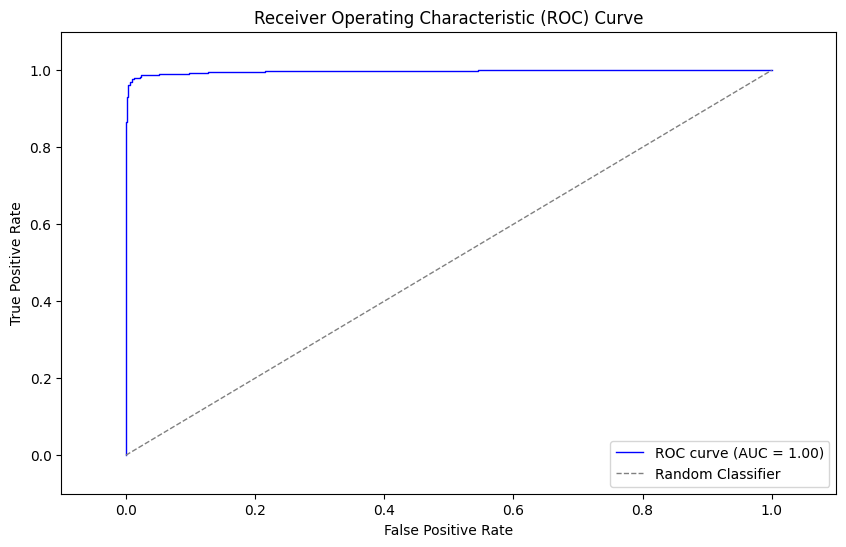

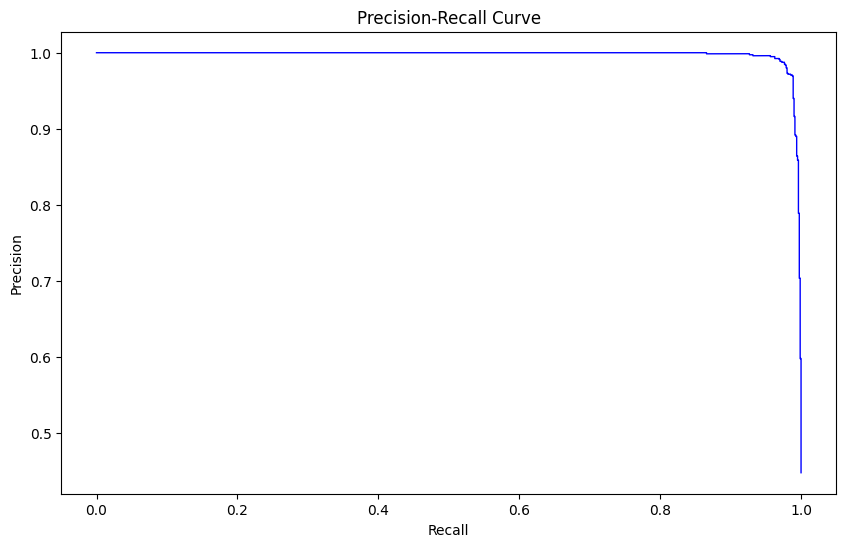

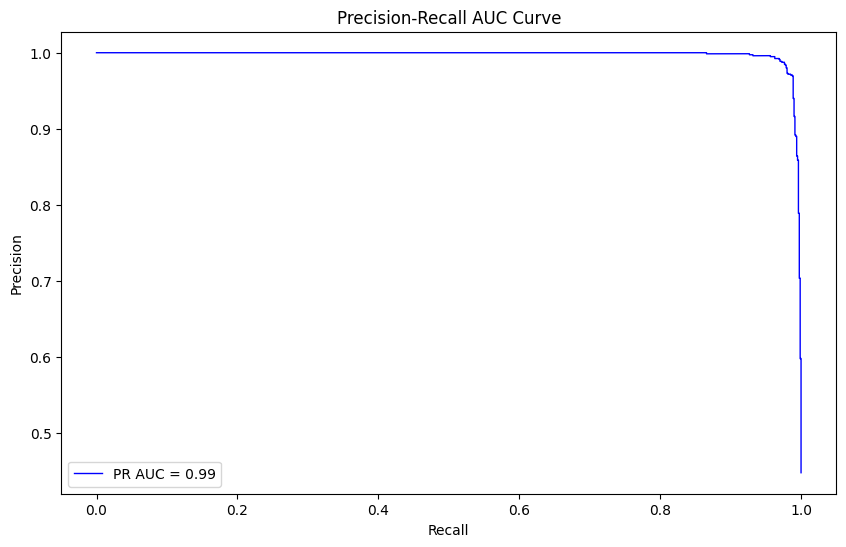

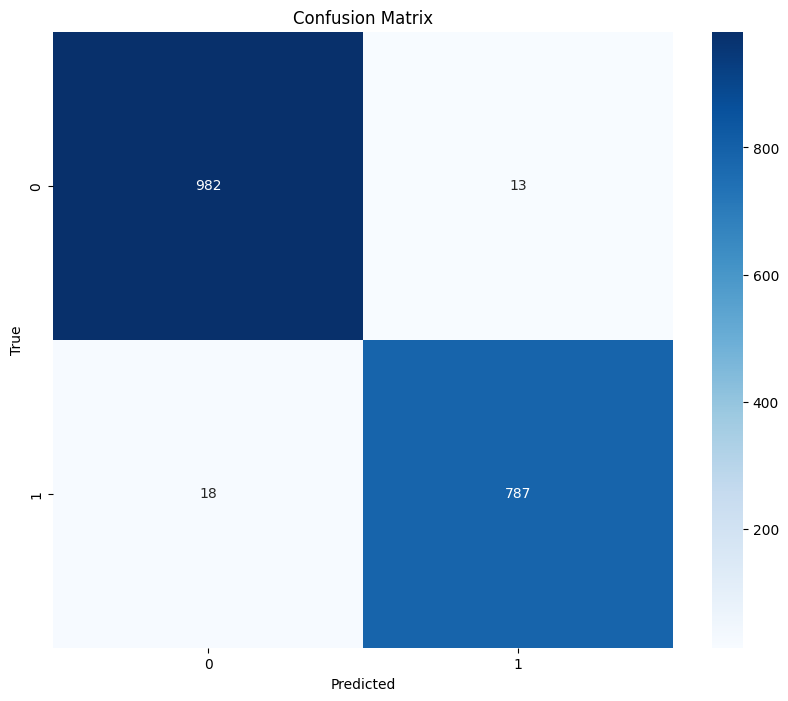

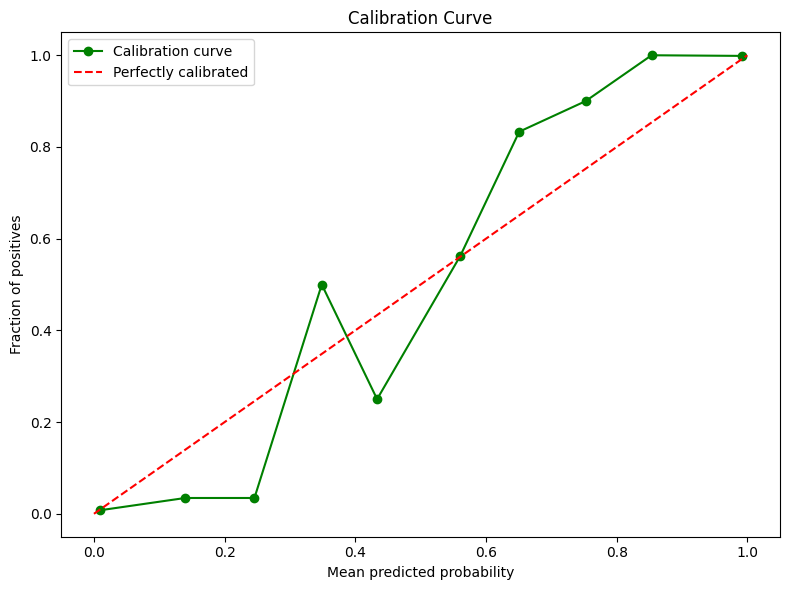

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.calibration import calibration_curve

# Initialize lists to store predicted and true labels
all_labels = []
all_predicted = []
outputs_list = []

# Switch to evaluation mode
model.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Get the model's outputs
        outputs = model(images)
        
        # Apply sigmoid and threshold (for multi-label classification)
        outputs = torch.sigmoid(outputs)
        predicted = (outputs > 0.5).float()  # Threshold at 0.5
        
        # Collect the predicted and true labels (as lists)
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())
        outputs_list.extend(outputs.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predicted = np.array(all_predicted)
outputs_list = np.array(outputs_list)

# Calculate Precision, Recall, F1 Score for each label (macro-average)
precision = precision_score(all_labels, all_predicted, average='macro')
recall = recall_score(all_labels, all_predicted, average='macro')
f1 = f1_score(all_labels, all_predicted, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels.ravel(), outputs_list.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=1, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Random Classifier')  # Dashed line with legend
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(all_labels.ravel(), outputs_list.ravel())
plt.figure(figsize=(10, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Plot Precision-Recall AUC Curve
pr_auc = average_precision_score(all_labels, outputs_list, average='macro')
plt.figure(figsize=(10, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=1, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall AUC Curve')
plt.legend(loc='lower left')
plt.show()

# Confusion Matrix for multi-label classification
cm = confusion_matrix(all_labels.flatten(), all_predicted.flatten())

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calibration Curve
# Calculate the calibration curve
prob_true, prob_pred = calibration_curve(all_labels.flatten(), outputs_list.flatten(), n_bins=10)

# Plot Calibration Curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', color='green', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Step 8: Make predictions

,Subcategory,Predictions (0 or 1),Probabilities
0,epidural,False,0.0074
1,intraparenchymal,False,0.0016
2,intraventricular,False,0.0022
3,subarachnoid,True,0.8960
4,subdural,False,0.0372
5,any,True,1.0000
6,Conclusion: The model predicts 'subarachnoid',with the highest probability of 89.60%.,"Scientific Description: Subarachnoid Hemorrhage: Bleeding in the space between the brain and the surrounding tissues, often due to aneurysm rupture."


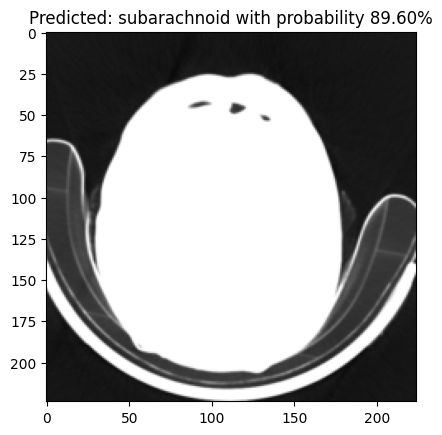

In [27]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Define the model with 6 output classes (matching the trained model)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 500)
        self.fc2 = nn.Linear(500, 6)  # Change to 6 output classes
    
    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)  # Flatten the output for fully connected layer
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the model with 6 output classes
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the saved model weights (which were trained for 6 subcategories)
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()

# Define the transform for image preprocessing (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Define the subcategories (for the 6 classes)
subcategories = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']

# Definitions for each hemorrhage type
definitions = {
    'epidural': 'Epidural Hemorrhage: Bleeding between the skull and dura mater, often caused by trauma.',
    'intraparenchymal': 'Intraparenchymal Hemorrhage: Bleeding within brain tissue, often from high blood pressure or trauma.',
    'intraventricular': 'Intraventricular Hemorrhage: Bleeding in the brain\'s ventricles, often caused by trauma or premature birth.',
    'subarachnoid': 'Subarachnoid Hemorrhage: Bleeding in the space between the brain and the surrounding tissues, often due to aneurysm rupture.',
    'subdural': 'Subdural Hemorrhage: Bleeding between the dura mater and brain, often from head trauma.',
    'any': 'Any Hemorrhage: A general category for any type of brain hemorrhage.'
}

# Function to read and convert an image to a format usable by PIL
def load_image(image_path):
    file_extension = os.path.splitext(image_path)[-1].lower()
    
    if file_extension == '.dcm':  # If it's a DICOM file
        dicom_data = pydicom.dcmread(image_path)
        img_array = dicom_data.pixel_array  # Get pixel data from DICOM
        img = Image.fromarray(img_array).convert("RGB")  # Convert to RGB format for PIL
    else:  # If it's a regular image (e.g., jpg, png)
        img = Image.open(image_path).convert("RGB")
    
    return img

# Function to make a prediction
def predict_image(image_path):
    # Load and preprocess the image
    img = load_image(image_path)
    img = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(img)
    
    # Get predicted probabilities (use sigmoid for multi-label classification)
    probabilities = torch.sigmoid(outputs)  # Sigmoid activation
    
    # Get the predicted classes (thresholded at 0.5)
    predicted_classes = (probabilities > 0.50).cpu().numpy().flatten()  # Threshold at 0.5

    # Map the predictions to the subcategories
    predictions = {subcategory: predicted_classes[i] for i, subcategory in enumerate(subcategories)}
    
    return predictions, probabilities, img

# Test with an example image (provide the image path here)
image_path = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_aa6c80174.dcm'  # Replace with your image path

# Make prediction
predictions, probabilities, img = predict_image(image_path)

# Prepare data for the table
table_data = []
for subcategory, prediction in predictions.items():
    prob = probabilities.flatten()[subcategories.index(subcategory)].item()
    table_data.append([subcategory, prediction, f"{prob:.4f}"])

# Add the conclusion row
sorted_probabilities = probabilities.flatten().tolist()

# Find the maximum probability, excluding 'any' since any is perfect - or it will have any hemorrhage
max_prob_index = sorted_probabilities.index(max(sorted_probabilities))  # Find max without 'any'
if subcategories[max_prob_index] == 'any':
    sorted_probabilities[max_prob_index] = -1  # Set 'any' to a very low value
    max_prob_index = sorted_probabilities.index(max(sorted_probabilities))

# Get the subcategory and probability
max_subcategory = subcategories[max_prob_index]
max_probability = probabilities.flatten()[max_prob_index].item() * 100  # Convert to percentage

conclusion = [f"Conclusion: The model predicts '{max_subcategory}'", f"with the highest probability of {max_probability:.2f}%.", f"Scientific Description: {definitions[max_subcategory]}"]

# Adjust pandas display settings to avoid truncation
pd.set_option('display.max_colwidth', None)  # Set no truncation for column width

# Convert the table data to a DataFrame
df = pd.DataFrame(table_data, columns=["Subcategory", "Predictions (0 or 1)", "Probabilities"])
df.loc[len(df)] = conclusion  # Add the conclusion as the last row

# Display the table
from IPython.display import display
display(df)

# Display the image (convert from Tensor to numpy array)
img = img.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Remove batch dimension and convert to HxWxC format
img = (img * 0.5) + 0.5  # Denormalize

# Plot the image
plt.imshow(img)
plt.axis('on')  # Enable ticks
plt.title(f"Predicted: {max_subcategory} with probability {max_probability:.2f}%")
plt.show()
